## Introduction:
In this project, we delve into a dataset of 61,069 mushrooms, classified into 173 species, with the aim of distinguishing between edible and poisonous varieties. Our analysis covers 15 distinct features, including aspects like cap shape and stem height. The goal is to develop and train a range of models that can accurately identify mushrooms based on these characteristics. We have employed various data preparation techniques, feature extraction methods, and applied machine learning models such as Random Forest and Multi-Layer Perceptron, all to achieve high accuracy in mushroom classification

### Import necessary libraries
---

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning models
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neural_network import MLPClassifier

### Load the datasets
---

In [2]:
# Load the training and test datasets
df = pd.read_csv('datasets/mushroom_train.csv', header='infer')
df_test = pd.read_csv('datasets/mushroom_test.csv', header='infer')

# Combine features (X) and targets (y) from both datasets for unified processing
x = pd.concat([df.iloc[:, :-1], df_test.iloc[:, :-1]], axis=0)
y = pd.concat([df.iloc[:, -1], df_test.iloc[:, -1]], axis=0)

# Create a single DataFrame combining features and targets
df = pd.concat([x, y], axis=1)

# Print the shape of the combined DataFrame to verify its size
print(df.shape)

(61069, 16)


In [194]:
df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e


#### Analyze Categorical Features to Understand the Dataset Better

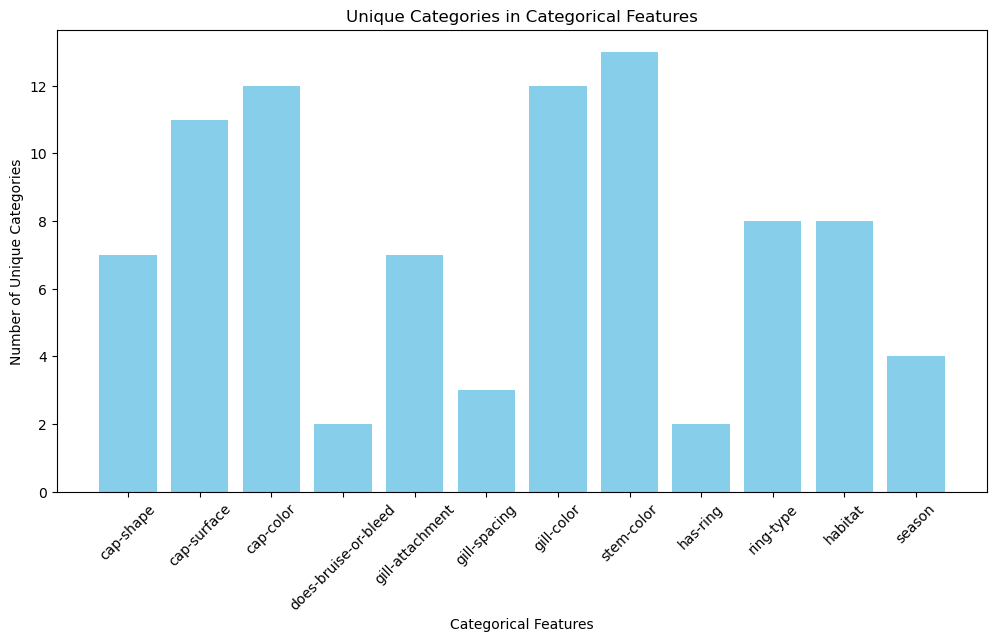

In [195]:
# List of categorical feature names in the dataset
categorical_columns = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing',
                         'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

# Calculate the number of unique categories for each categorical feature
unique_categories = {column: x[column].nunique() for column in categorical_columns}
# for column, i in unique_categories.items():
#     print(f"{column}: {i} unique categories")

# Data Visualization: Bar Plot for Unique Categories in Each Feature
# Extract feature names and their corresponding number of unique categories
features, num_unique_categories = zip(*unique_categories.items())

# Creating a bar plot
plt.figure(figsize=(12, 6))
plt.bar(features, num_unique_categories, color='skyblue')
plt.xlabel('Categorical Features')
plt.ylabel('Number of Unique Categories')
plt.title('Unique Categories in Categorical Features')
plt.xticks(rotation=45)
plt.show()


#### Convert Class Labels to Binary Format for Easier Processing

In [196]:
# 'p' for poisonous is mapped to 0, and 'e' for edible is mapped to 1
y = y.map({'p': 0, 'e': 1}).values

### Trivial System
#### A system that outputs class assignments (S0, S1) at random with probability N0/N and N1/N, respectively; 𝑁i is the number of training data points with class label Si, and N is the total number of training data points.
---

Estimated probability of class 0: 0.5549132947976878
Estimated probability of class 1: 0.44508670520231214
Accuracy Rate: 50.62306571255465%
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.56     33888
           1       0.45      0.44      0.44     27181

    accuracy                           0.51     61069
   macro avg       0.50      0.50      0.50     61069
weighted avg       0.51      0.51      0.51     61069



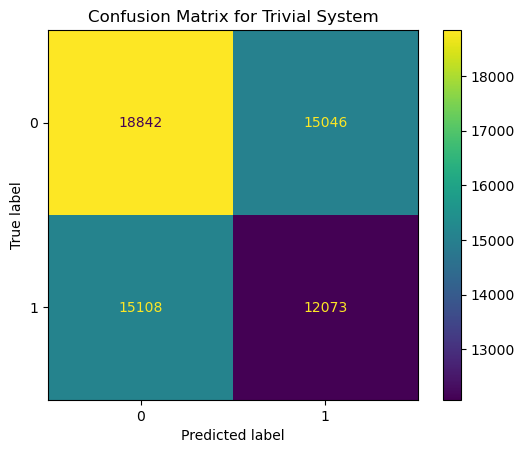

In [197]:
def trivial_system(p_s0, p_s1, size):
    classes = [0, 1]
    output = random.choices(classes, [p_s0, p_s1], k=size)
    return np.array(output)

# Calculate the probabilities of each class in the dataset
N0 = np.sum(y == 0)
N1 = np.sum(y == 1)
N = len(y)
p0 = N0 / N
p1 = N1 / N

print("Estimated probability of class 0:", p0)
print("Estimated probability of class 1:", p1)

# Generate predictions using the trivial system
y_pred = trivial_system(p0, p1, len(y))

# Calculate and print the accuracy rate
accuracy_rate = accuracy_score(y, y_pred) * 100
print(f"Accuracy Rate: {accuracy_rate}%")

# Generate and print classification report
print("Classification Report:\n", classification_report(y, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Trivial System')
plt.show()


### Baseline System: Nearest Centroid Classifier
---

Training set - Classification report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65     27097
           1       0.56      0.52      0.54     21758

    accuracy                           0.60     48855
   macro avg       0.60      0.60      0.60     48855
weighted avg       0.60      0.60      0.60     48855

Training set - Accuracy: 0.6034796847814963

Validation set - Classification report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      6791
           1       0.54      0.52      0.53      5423

    accuracy                           0.59     12214
   macro avg       0.59      0.58      0.58     12214
weighted avg       0.59      0.59      0.59     12214

Validation set - Accuracy: 0.5921892909775667


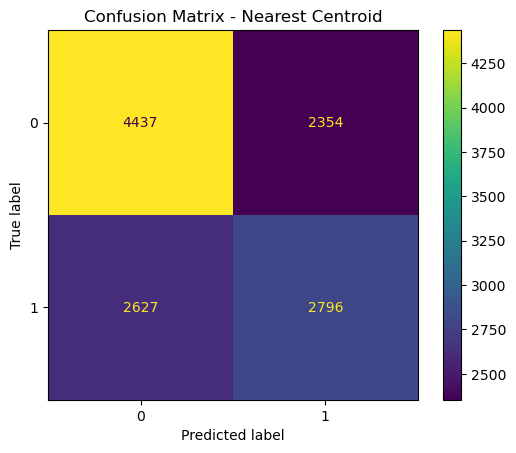

In [198]:
# One-Hot Encoding of Categorical Features
x_encoded = pd.get_dummies(x, columns=categorical_columns)

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Initialize and fit the NearestCentroid classifier
nc_classifier = NearestCentroid()
nc_classifier.fit(x_train, y_train)

# Making predictions on the training set and computing the report
y_pred = nc_classifier.predict(x_train)
print("Training set - Classification report:\n", classification_report(y_train, y_pred))
print("Training set - Accuracy:", accuracy_score(y_train, y_pred))

# Making predictions on the validation set and computing the report
y_pred_val = nc_classifier.predict(x_val)
print("\nValidation set - Classification report:\n", classification_report(y_val, y_pred_val))
print("Validation set - Accuracy:", accuracy_score(y_val, y_pred_val))

# Confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot()
plt.title('Confusion Matrix - Nearest Centroid')
plt.show()


### Feature Aggregation 
---

In [199]:
# Polynomial Features
# Creating polynomial features to capture interactions between features
poly = PolynomialFeatures(degree=3) # degree 3
# Fit and transform the selected features into polynomial features
poly_features = poly.fit_transform(df[['stem-width', 'stem-height', 'cap-diameter']])

# Combine original and polynomial features
# Convert the array of polynomial features into a DataFrame for easier manipulation
poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['stem-width', 'stem-height', 'cap-diameter']))

# Standardization
# Standardize the features (both original and polynomial) to have a mean of 0 and variance of 1
scaler = StandardScaler()
df_poly = pd.DataFrame(scaler.fit_transform(poly_features), columns=poly_features.columns)

print(df_poly.shape)
# Optionally, uncomment the next line to print the polynomial features
# print(df_poly.columns)

(61069, 20)


#### One-Hot Encoding of Categorical Features

In [200]:
categorical_columns = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment',
                       'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']

df_encoded = pd.get_dummies(df[['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment',
                       'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']], columns=categorical_columns)

print(df_encoded.shape)
# print(df_encoded.columns)

(61069, 89)


#### Combine All of the Extracted Features

In [201]:
df_poly = df_poly.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)
df_combined = pd.concat([df_poly, df_encoded], axis=1)
# df_test_combined = pd.concat([df_test_poly, df_test_encoded], axis=1)

print(df_combined.shape)
# print(df_combined.columns)

(61069, 109)


### Feature Selection
---

####  SelecetKBest()

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


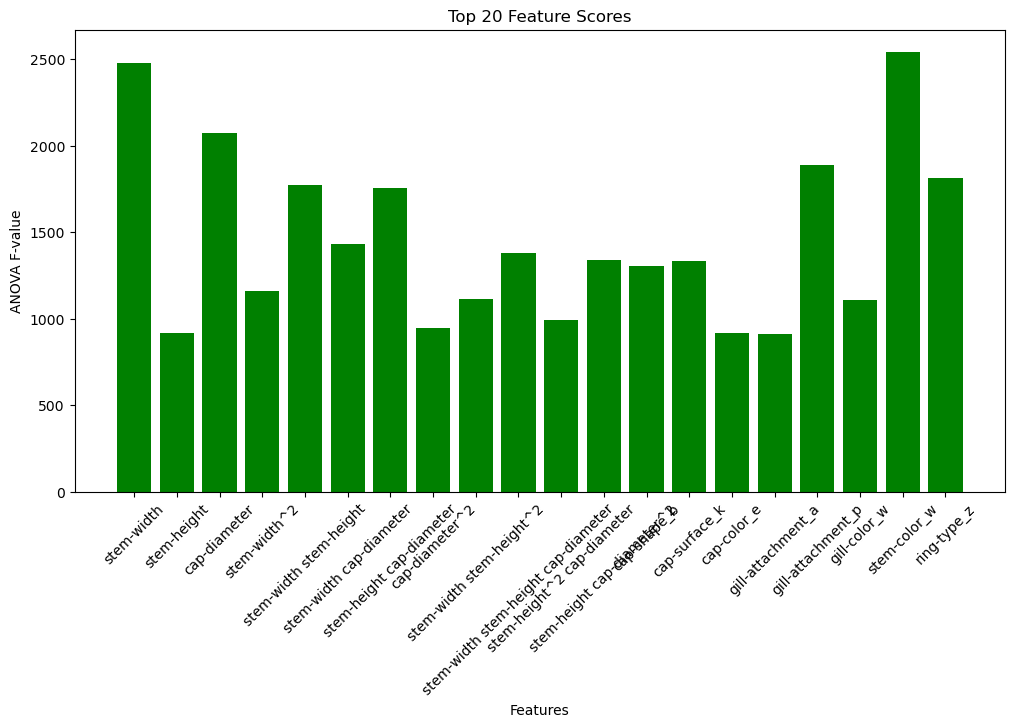

In [202]:
# Select the top N features
# SelectKBest is used to select features according to the k highest scores
selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(df_combined, y)

# Get the boolean mask indicating which features are selected
selected_features_mask = selector.get_support()

# Get the names of the selected features
selected_features = df_combined.columns[selected_features_mask]
# print("Selected Features:", selected_features)

# Visualizing the scores of the selected features
# Extract the scores assigned to each feature
feature_scores = selector.scores_[selected_features_mask]

# Creating a bar plot for feature scores
plt.figure(figsize=(12, 6))
plt.bar(selected_features, feature_scores, color='green')
plt.xlabel('Features')
plt.ylabel('ANOVA F-value')
plt.title('Top 20 Feature Scores')
plt.xticks(rotation=45)
plt.show()

#### Several Model Evaluations on the Selected Features

Accuracy for NearestCentroid: 0.59 (+/- 0.01)
Accuracy for LogisticRegression: 0.72 (+/- 0.01)
Accuracy for GradientBoostingClassifier: 0.83 (+/- 0.01)
Accuracy for RandomForestClassifier: 0.94 (+/- 0.00)


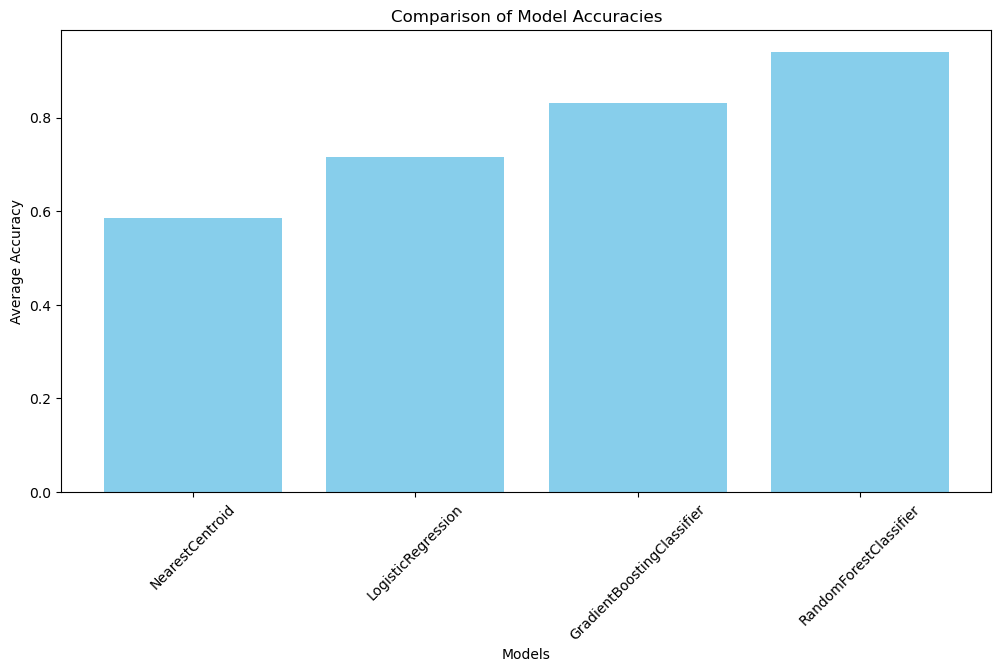

In [168]:
# Function to evaluate a given model using K-Fold cross-validation
def evaluate_model(model, X, y, cv_folds=5):
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42) # K-fold
    scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(accuracy_score))  #  cross-validated scores
    print(f"Accuracy for {model.__class__.__name__}: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
    return scores.mean()

models = [
    NearestCentroid(),
    LogisticRegression(max_iter=1000, random_state=42),
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

# Store model names and their corresponding average accuracies
model_names = []
accuracies = []

# Evaluate each model and store their performance
for model in models:
    model_names.append(model.__class__.__name__)
    accuracies.append(evaluate_model(model, X_new, y))

# Visualize model performances
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.show()

### Grid-Search for Hyperparameter Tuning on the following classifiers: Logistic Regression, Gradient Boosting, Random Forest, MLP
---

In [203]:
# split the dataset into training and val sets
x_train, x_val, y_train, y_val = train_test_split(X_new, y, test_size=0.3, random_state=42)

#### Logistic Regression

In [170]:
# Logistice regression 
lr_model = LogisticRegression(random_state=42)

# Hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Different penalties
    'solver': ['saga', 'lbfgs'], # Optimization algorithms
    'max_iter': [2000, 5000] # Maximum iterations for solver convergence
}

# Grid search with cross-validation
grid_search_lr = GridSearchCV(lr_model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_lr.fit(x_train, y_train)

# Extracting the best hyperparameters and model
best_params_lr = grid_search_lr.best_params_
best_estimator_lr = grid_search_lr.best_estimator_
print("Best parameters found by grid search for Logistic Regression:")
print(best_params_lr)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/k

Best parameters found by grid search for Logistic Regression:
{'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}


Train accuracy: 0.7189576120520258
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75     23683
           1       0.70      0.65      0.68     19065

    accuracy                           0.72     42748
   macro avg       0.72      0.71      0.71     42748
weighted avg       0.72      0.72      0.72     42748

val accuracy: 0.7194476284045631

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75     10205
           1       0.69      0.66      0.68      8116

    accuracy                           0.72     18321
   macro avg       0.72      0.71      0.71     18321
weighted avg       0.72      0.72      0.72     18321



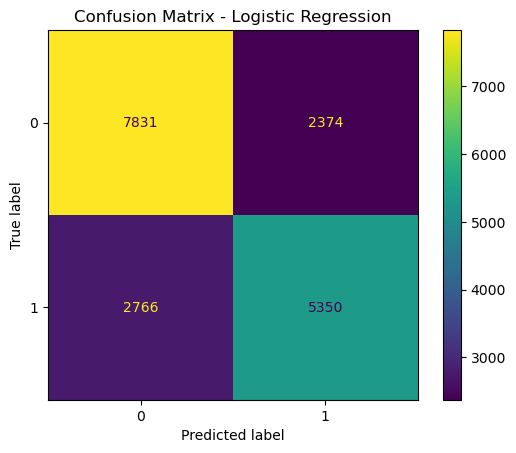

In [204]:
# train set: make predictions
y_pred = best_estimator_lr.predict(x_train)
# compute accuracy rate and report
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)
print("Classification report:\n", classification_report(y_train, y_pred))

# val set: make predictions
y_pred = best_estimator_lr.predict(x_val)
# compute accuracy rate and classification report
accuracy = accuracy_score(y_val, y_pred)
print("val accuracy:", accuracy)
print("\nClassification report:\n", classification_report(y_val, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator_lr.classes_)
disp.plot()
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


In [188]:
# Save the model
lg_model = './trained_models/logistic_regression_model.joblib'
dump(best_estimator_lr, lg_model) 

# # Load the model from the file
# lg_model = load('./trained_models/logistic_regression_model.joblib')


['./logistic_regression_model.joblib']

#### Gradient Boosting

In [128]:
# Gradient Boosting

gradient_boosting = GradientBoostingClassifier(random_state=42)

# Hyperparameter tuning using grid search with cross-validation
param_grid_gb = {
    'n_estimators': [100, 200],  # Number of boosting stages to perform
    'learning_rate': [0.01, 0.1],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 4],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # The minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # The number of features to consider when looking for the best split
}

# Grid search with cross-validation
grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_gb.fit(x_train, y_train)

# Extracting the best hyperparameters and model
best_params_gb = grid_search_gb.best_params_
best_estimator_gb = grid_search_gb.best_estimator_
print("Best parameters found by grid search for Gradient Boosting Classifier:")
print(best_params_gb)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found by grid search for Gradient Boosting Classifier:
{'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Train accuracy: 0.966969214934032
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     23683
           1       0.96      0.96      0.96     19065

    accuracy                           0.97     42748
   macro avg       0.97      0.97      0.97     42748
weighted avg       0.97      0.97      0.97     42748

val accuracy: 0.935156377926969

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10205
           1       0.93      0.93      0.93      8116

    accuracy                           0.94     18321
   macro avg       0.93      0.93      0.93     18321
weighted avg       0.94      0.94      0.94     18321



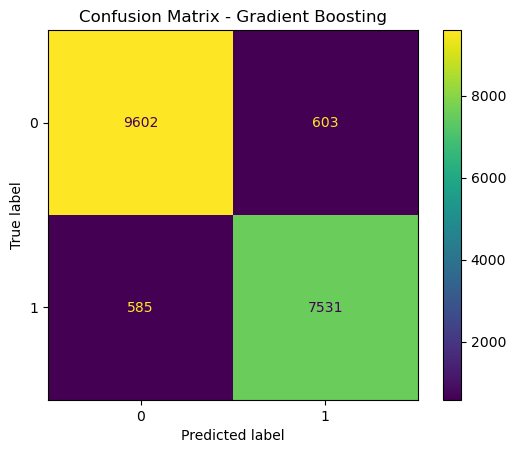

In [205]:
# train set: make predictions
y_pred = best_estimator_gb.predict(x_train)
# compute accuracy rate and report
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)
print("Classification report:\n", classification_report(y_train, y_pred))

# val set: make predictions
y_pred = best_estimator_gb.predict(x_val)
# compute accuracy rate and classification report
accuracy = accuracy_score(y_val, y_pred)
print("val accuracy:", accuracy)
print("\nClassification report:\n", classification_report(y_val, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator_gb.classes_)
disp.plot()
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

In [130]:
# Save the model to a file
gb_model = './trained_models/gradient_boosting_model.joblib'
dump(best_estimator_gb, gb_model) 

# # Load the model from the file
# gb_model = load('./trained_models/gradient_boosting_model.joblib')

['./gradient_boosting_model.joblib']

#### Random Forest


In [131]:
# Random Forest

random_forest = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using grid search with cross-validation
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Method for sampling data points
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(x_train, y_train)

# Extracting the best hyperparameters and model
best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_
print("Best parameters found by grid search for Random Forest Classifier:")
print(best_params_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found by grid search for Random Forest Classifier:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Train accuracy: 0.9837419294469917
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     23683
           1       0.98      0.98      0.98     19065

    accuracy                           0.98     42748
   macro avg       0.98      0.98      0.98     42748
weighted avg       0.98      0.98      0.98     42748

val accuracy: 0.9394137874570165

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10205
           1       0.93      0.93      0.93      8116

    accuracy                           0.94     18321
   macro avg       0.94      0.94      0.94     18321
weighted avg       0.94      0.94      0.94     18321



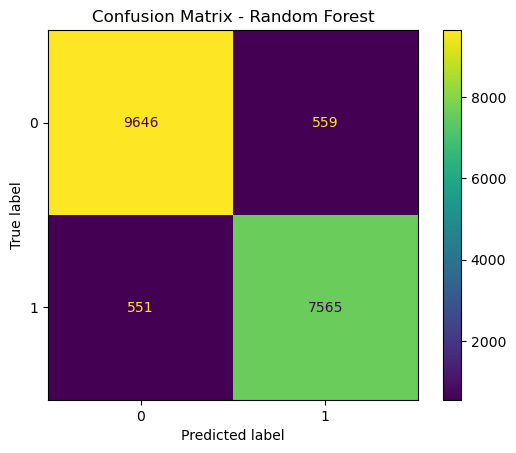

In [206]:
# train set: make predictions
y_pred = best_estimator_rf.predict(x_train)
# compute accuracy rate and report
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)
print("Classification report:\n", classification_report(y_train, y_pred))

# val set: make predictions
y_pred = best_estimator_rf.predict(x_val)
# compute accuracy rate and report
accuracy = accuracy_score(y_val, y_pred)
print("val accuracy:", accuracy)
print("\nClassification report:\n", classification_report(y_val, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator_rf.classes_)
disp.plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [133]:
# Save the model to a file
rf_model = './trained_models/random_forest_model.joblib'
dump(best_estimator_rf, rf_model) 

# # Load the model from the file
# rf_model = load('./trained_models/random_forest_model.joblib')

['./random_forest_model.joblib']

#### Multi-layer Perceptron

In [134]:
# Multi-layer Perceptron

mlp = MLPClassifier(max_iter=3000, random_state=42)

# hyperparameter tuning using grid search with cross validation
param_grid = {
    'hidden_layer_sizes': [(32), (64), (64, 32)],
    'solver': ['adam', 'sgd'],
    'alpha': [0.00001, 0.0001, 0.001],
    'activation':['relu','tanh'],
}

# Perform the grid search
grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator_mlp = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found by grid search:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'solver': 'adam'}


Train accuracy: 0.9480677458594554
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     23683
           1       0.94      0.94      0.94     19065

    accuracy                           0.95     42748
   macro avg       0.95      0.95      0.95     42748
weighted avg       0.95      0.95      0.95     42748

val accuracy: 0.9412149991812674

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     10205
           1       0.93      0.94      0.93      8116

    accuracy                           0.94     18321
   macro avg       0.94      0.94      0.94     18321
weighted avg       0.94      0.94      0.94     18321



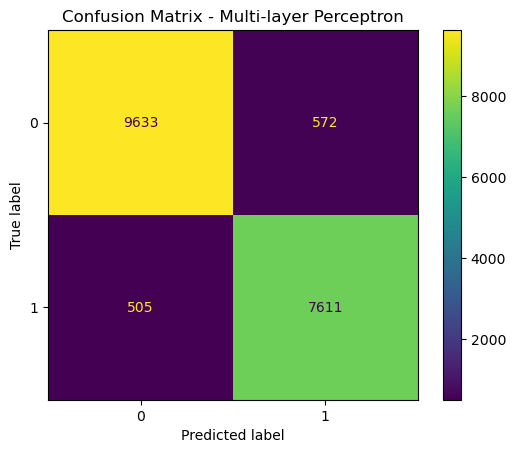

In [207]:
# train set: make predictions
y_pred = best_estimator_mlp.predict(x_train)
# compute accuracy rate and report
accuracy = accuracy_score(y_train, y_pred)
print("Train accuracy:", accuracy)
print("Classification report:\n", classification_report(y_train, y_pred))

# val set: make predictions
y_pred = best_estimator_mlp.predict(x_val)
# compute accuracy rate and report
accuracy = accuracy_score(y_val, y_pred)
print("val accuracy:", accuracy)
print("\nClassification report:\n", classification_report(y_val, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator_mlp.classes_)
disp.plot()
plt.title('Confusion Matrix - Multi-layer Perceptron')
plt.show()

In [136]:
# Save the model to a file
mlp_model = './trained_models/multilayer_perceptron_model.joblib'
dump(best_estimator_mlp, mlp_model) 

# # Load the model from the file
# mlp_model = load('./trained_models/multilayer_perceptron_model.joblib')

['./multilayer_perceptron_model.joblib']

## Summary:
At the end of our project, we successfully used data processing and machine learning to classify mushrooms. We learned which features are most important and how different models perform. Our work shows that with the right data and tools, we can effectively tell apart edible and poisonous mushrooms. This is useful for anyone interested in mushrooms, from experts to everyday enthusiasts, providing a good example of how machine learning can be applied in real life.